# 6-1 프로젝트 : 네이버 영화리뷰 감성분석
## 0. 라이브러리

In [24]:
import pandas as pd
import konlpy
import gensim
import tensorflow as tf
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1. 데이터 준비와 확인
### 1.1 데이터 불러오기

In [53]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

### 1.2 데이터 확인

In [54]:
print(train_data.head())
print(test_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


## 2. 데이터로 구성
### 2.0 필요 라이브러리

In [55]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

### 2.1 데이터로 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전(word_to_index) 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [56]:
# 한국어 형태소 분석기
tokenizer = Mecab()
# 제외할 불용어 목록
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 데이터 정의
def load_data(train_data, test_data, num_words=10000):
    
    # 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 결측값 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화, 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 사전 생성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) # 빈도수 계산
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 인덱스 리스트 변환 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

### 2.2 딕셔너리 단어 정리
- "PAD", "BOS", "UNK", "UNUSED" 추가
- index_to_word 생성

In [57]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3
index_to_word = {index:word for word, index in word_to_index.items()}

top_5_dic = {k: index_to_word[k] for k in sorted(index_to_word)[:5]}

print(top_5_dic)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.'}


### 2.3 encode, decode 함수 정의

In [58]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [59]:
print(index_to_word[1])
print(word_to_index['영화']) 
print(index_to_word[0])     

print(get_decoded_sentence(X_train[1], index_to_word))

<BOS>
5
<PAD>
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나


### 3.1 토큰의 길이 저장
- num_tokens

In [64]:
total_data_text = list(X_train) + list(X_test) # 숫자들의 리스트 합 25000+25000= 50000

num_tokens = [len(tokens) for tokens in total_data_text] # 각 문장의 토큰 길이 저장
num_tokens = np.array(num_tokens)
print(num_tokens)

[10 17  3 ... 15 23  4]


### 3.2 데이터셋 내 문장 길이 분포
- 문장길이 평균, 최대, 표준편차

In [65]:
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


### 3.3 최대 문장 길이 지정
- 최대 길이 = 평균 + 2*표준편차

In [66]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 소수점 처리
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 3.4 패딩추가
- 패딩을 단어 앞에 추가 (padding='pre')
- 최대길이 지정

In [67]:
import numpy as np
import tensorflow as tf
import os

In [68]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen) 

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape,X_test.shape)

(146182, 41) (49157, 41)


## 4. 모델 구성 및 validation set 구성
### 4.1 모델구성
- 단방향 LSTM

In [70]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) # 임베딩 레이어는 입력된 단어 인덱스를 임베딩 벡터
model.add(tf.keras.layers.LSTM(8)) 
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 4.2 validataion set
- 훈련:검증 = 60:40

In [71]:
# validation set (40%)
X_val = X_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 (60%)
partial_X_train = X_train[60000:]  
partial_y_train = y_train[60000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(86182, 41)
(86182,)
(60000, 41)
(60000,)


## 5. 모델 훈련 개시
### 5.1 모델 학습
- epochs=20
- batch_size=512 (한번에 512문장)
- 검증 데이터 사용

In [74]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 3s 9ms/step - loss: 0.1864 - accuracy: 0.9321 - val_loss: 0.4696 - val_accuracy: 0.8348
Epoch 2/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1780 - accuracy: 0.9362 - val_loss: 0.4871 - val_accuracy: 0.8341
Epoch 3/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1722 - accuracy: 0.9390 - val_loss: 0.4979 - val_accuracy: 0.8332
Epoch 4/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1666 - accuracy: 0.9412 - val_loss: 0.5215 - val_accuracy: 0.8328
Epoch 5/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1608 - accuracy: 0.9437 - val_loss: 0.5463 - val_accuracy: 0.8326
Epoch 6/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1568 - accuracy: 0.9453 - val_loss: 0.5615 - val_accuracy: 0.8296
Epoch 7/20
169/169 [==============================] - 1s 6ms/step - loss: 0.1517 - accuracy: 0.9471 - val_loss: 0.5466 - val_accuracy: 0.8298
Epoch 

### 5.2 모델 평가
- 테스트 셋
- accuracy: 0.8195

In [75]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7988 - accuracy: 0.8195
[0.7987934350967407, 0.8195374011993408]


### 5.2-2 모델2 평가
- conv,maxpool모델 
- accuracy: 0.8220

In [99]:
vocab_size = 10000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu')) # 16개필터, 필터크기:7
model.add(tf.keras.layers.MaxPooling1D(5)) # 5단어중 최댓값
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D()) # 전체중 최댓값
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

Epoch 1/10
169/169 [==============================] - 3s 7ms/step - loss: 0.5785 - accuracy: 0.6762 - val_loss: 0.3839 - val_accuracy: 0.8295
Epoch 2/10
169/169 [==============================] - 1s 6ms/step - loss: 0.3438 - accuracy: 0.8526 - val_loss: 0.3616 - val_accuracy: 0.8386
Epoch 3/10
169/169 [==============================] - 1s 6ms/step - loss: 0.2986 - accuracy: 0.8755 - val_loss: 0.3522 - val_accuracy: 0.8481
Epoch 4/10
169/169 [==============================] - 1s 5ms/step - loss: 0.2669 - accuracy: 0.8918 - val_loss: 0.3593 - val_accuracy: 0.8458
Epoch 5/10
169/169 [==============================] - 1s 6ms/step - loss: 0.2362 - accuracy: 0.9067 - val_loss: 0.3766 - val_accuracy: 0.8431
Epoch 6/10
169/169 [==============================] - 1s 6ms/step - loss: 0.2015 - accuracy: 0.9243 - val_loss: 0.4038 - val_accuracy: 0.8407
Epoch 7/10
169/169 [==============================] - 1s 6ms/step - loss: 0.1697 - accuracy: 0.9387 - val_loss: 0.4402 - val_accuracy: 0.8377
Epoch 

### 5.2-3 모델3 평가
- 양방향 lstm모델
- accuracy: 0.8329

In [100]:
vocab_size = 10000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

Epoch 1/10
169/169 [==============================] - 11s 40ms/step - loss: 0.4541 - accuracy: 0.7753 - val_loss: 0.3611 - val_accuracy: 0.8421
Epoch 2/10
169/169 [==============================] - 6s 33ms/step - loss: 0.3361 - accuracy: 0.8573 - val_loss: 0.3545 - val_accuracy: 0.8459
Epoch 3/10
169/169 [==============================] - 6s 34ms/step - loss: 0.3173 - accuracy: 0.8671 - val_loss: 0.3606 - val_accuracy: 0.8446
Epoch 4/10
169/169 [==============================] - 6s 34ms/step - loss: 0.3044 - accuracy: 0.8739 - val_loss: 0.3628 - val_accuracy: 0.8450
Epoch 5/10
169/169 [==============================] - 6s 34ms/step - loss: 0.2921 - accuracy: 0.8790 - val_loss: 0.3598 - val_accuracy: 0.8440
Epoch 6/10
169/169 [==============================] - 6s 34ms/step - loss: 0.2772 - accuracy: 0.8860 - val_loss: 0.3632 - val_accuracy: 0.8430
Epoch 7/10
169/169 [==============================] - 6s 34ms/step - loss: 0.2614 - accuracy: 0.8928 - val_loss: 0.3704 - val_accuracy: 0.843

## 6. Loss, Accuracy 그래프 시각화
### 6.1 그래프에 그릴 항목 선정
- loss
- accuracy
- val_loss
- val_accuracy

In [78]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6.2 loss 그래프

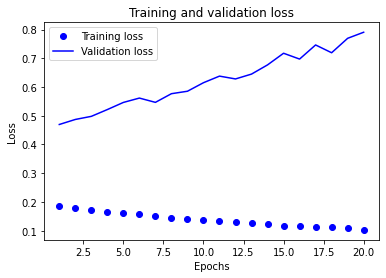

In [79]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6.3 accuracy 그래프

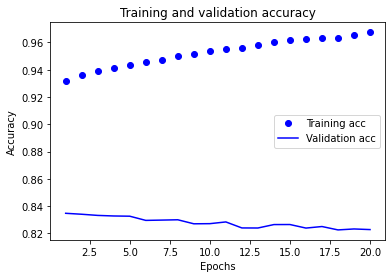

In [80]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석
### 7.1 가중치 크기
- (vocab_size, embedding_dim)

In [102]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


### 7.2 Embeding 파라미터 저장
- 워드 벡터 기록

In [103]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [104]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['최고']
vector

array([-0.07856137,  0.11014929, -0.08599409, -0.12468211, -0.13319035,
       -0.10015228,  0.12387984,  0.09400652, -0.09445904,  0.13370883,
       -0.05995641,  0.10267917, -0.09277486, -0.12663747, -0.12027933,
        0.0503078 ], dtype=float32)

### 7.3 비슷한 단어 출력
- 유의미한 결과라고 보기 어려움
- 감성 분류 태스크를 잠시 학습한 것으로는 부족

In [105]:
word_vectors.similar_by_word("끝")

[('무적', 0.8172757625579834),
 ('핵', 0.7430548071861267),
 (']', 0.7296878099441528),
 ('고쳐', 0.7241611480712891),
 ('?', 0.7229514718055725),
 ('소고기', 0.7161387205123901),
 ('여배우', 0.7131151556968689),
 ('결국', 0.7123728394508362),
 ('그게', 0.7049015164375305),
 ('뻔', 0.7048646211624146)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선
### 8.0 라이브러리

In [90]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

### 8.1 한국어 Word2Vec 모델 불러오기
- 100차원

In [91]:
word_vectors = Word2VecKeyedVectors.load('../data/word2vec_ko.model')
vector = word_vectors.wv['끝']

### 8.2 비슷한 단어 출력
- 비슷한 단어가 잘 정리되어 있음

In [92]:
word_vectors.wv.similar_by_word("끝")

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

### 8.3 입력 데이터 크기 확인
- 100 차원

In [93]:
word_vector_dim = word_vectors.vector_size
print(f"Word2Vec 모델의 벡터 차원: {word_vector_dim}")

Word2Vec 모델의 벡터 차원: 100


### 8.4 모델 준비 단계
- embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피

In [94]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

### 8.5 모델 구성
- 입력: 10000개의 단어, 100차원
- 양방향 lstm 
- dropout 적용

In [95]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         234496    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### 8.6 모델 학습
- early_stopping 적용
- 배치크기: 64

In [96]:
from tensorflow.keras.callbacks import EarlyStopping

In [97]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
1347/1347 [==============================] - 24s 15ms/step - loss: 0.3968 - accuracy: 0.8189 - val_loss: 0.3417 - val_accuracy: 0.8479
Epoch 2/20
1347/1347 [==============================] - 19s 14ms/step - loss: 0.2992 - accuracy: 0.8746 - val_loss: 0.3248 - val_accuracy: 0.8597
Epoch 3/20
1347/1347 [==============================] - 19s 14ms/step - loss: 0.2499 - accuracy: 0.8973 - val_loss: 0.3457 - val_accuracy: 0.8579


### 8.7 모델 평가
- acc : 0.8543

In [98]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3293 - accuracy: 0.8543
[0.3293062746524811, 0.8543035387992859]


## 회고
### 배운점 : 
- 텍스트 분석은 conv,maxpool로도 가능하다
- 사전 학습 모델을 사용할 경우 모델의 성능이 향상된다

### 아쉬운점:
- 단어의 전처리에 어려움을 겪었다.
- 사전학습모델의 경우 학습초기에 과적합이 발생하는 것 같았다.

### 느낀점:
- 상황에 맞는 사전 학습모델을 설정하는 것이 중요하다
- 텍스트 분석을 하기위해 단어의 전처리과정이 중요하다

### 어려웠던점:
- 모델의 튜닝에 시간이 걸렸고, local환경 설정이 어려웠다.